# Brain Tumor Classification from MRI Imaging

### Capstone Three

Naomi Lopez 

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import pandas as pd
import random
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras import Sequential 
from tensorflow.keras import models
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow .keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder 

2024-10-18 18:15:50.584303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [48]:
# Define a function to load images and labels from the specified directory
def load_data(directory):
    images = []
    labels = []
    
    # Loop through each class directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Check if class_path is a directory
        if not os.path.isdir(class_path):
            print(f"Skipping non-directory: {class_path}")
            continue
        
        images_path = os.path.join(class_path, 'images')
        labels_path = os.path.join(class_path, 'labels')

        # Check if both images and labels directories exist
        if not os.path.isdir(images_path) or not os.path.isdir(labels_path):
            print(f"Invalid directory structure in {class_path}. Skipping.")
            continue
        
        # Use class_name as the category label
        category_label = class_name 
        
        # Loop through each image in the images directory
        for image in os.listdir(images_path):
            if image.startswith('.'):  # Skip hidden files
                continue

            img_path = os.path.join(images_path, image)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image {image}, skipping.")
                continue
            
            
            # Corresponding label file
            label_file = image.rsplit('.', 1)[0] + '.txt'  # Match the image and label file names
            label_file_path = os.path.join(labels_path, label_file)
            
            # Check if the label file exists and is not empty
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip()
                    
                    if label_data:  # Ensure label data is not empty
                        images.append(img)
                        labels.append(category_label)  # Append the category label
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    
    return images, labels

# Paths to data directories
train_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'
val_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val'


In [47]:
# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train/.DS_Store
Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/.DS_Store
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/No Tumor/labels/image(55).txt not found, skipping this image.
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/Glioma/labels/gg (342).txt is empty, skipping this image.


In [4]:
# Print the number of images loaded and unique categories for training data
print(f'Loaded {len(train_images)} images from {len(set(train_labels))} categories.')
print('Training Categories:', set(train_labels))

Loaded 3670 images from 4 categories.
Training Categories: {'No Tumor', 'Pituitary', 'Meningioma', 'Glioma'}


In [5]:
# Print the number of images loaded and unique categories for validation data
print(f'Loaded {len(val_images)} images from {len(set(val_labels))} categories.')
print('Validation Categories:', set(val_labels))

Loaded 509 images from 4 categories.
Validation Categories: {'No Tumor', 'Pituitary', 'Meningioma', 'Glioma'}


In [6]:
# Convert validation labels to a NumPy array for counting
val_labels_np = np.array(val_labels)

# Get unique classes and their counts for validation data
unique_val_classes, val_class_counts = np.unique(val_labels_np, return_counts=True)

# Print class counts for validation data
for class_name, count in zip(unique_val_classes, val_class_counts):
    print(f'Class: {class_name}, Count: {count}')

print(f'Number of images in Validation data: {len(val_images)}')


Class: Glioma, Count: 135
Class: Meningioma, Count: 140
Class: No Tumor, Count: 98
Class: Pituitary, Count: 136
Number of images in Validation data: 509


In [49]:
# Visualize class counts for training and validation data
train_class_counts = dict(zip(set(train_labels), [train_labels.count(x) for x in set(train_labels)]))
val_class_counts = dict(zip(unique_val_classes, val_class_counts))


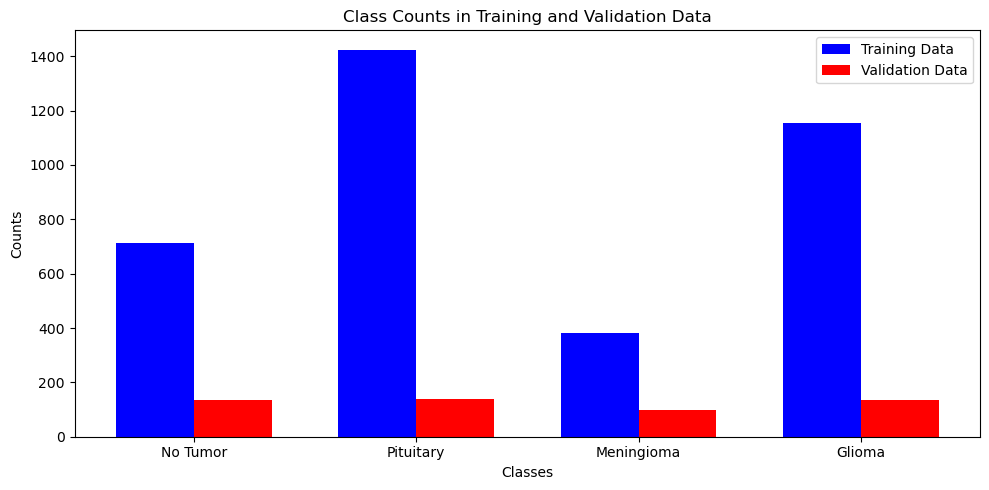

In [8]:
# Prepare data for plotting
categories = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
val_counts = list(val_class_counts.values())

# Bar width and positions
bar_width = 0.35
x = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, train_counts, width=bar_width, label='Training Data', color='b')
plt.bar(x + bar_width/2, val_counts, width=bar_width, label='Validation Data', color='r')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts in Training and Validation Data')
plt.xticks(x, categories)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Visualize Unaugmented Images

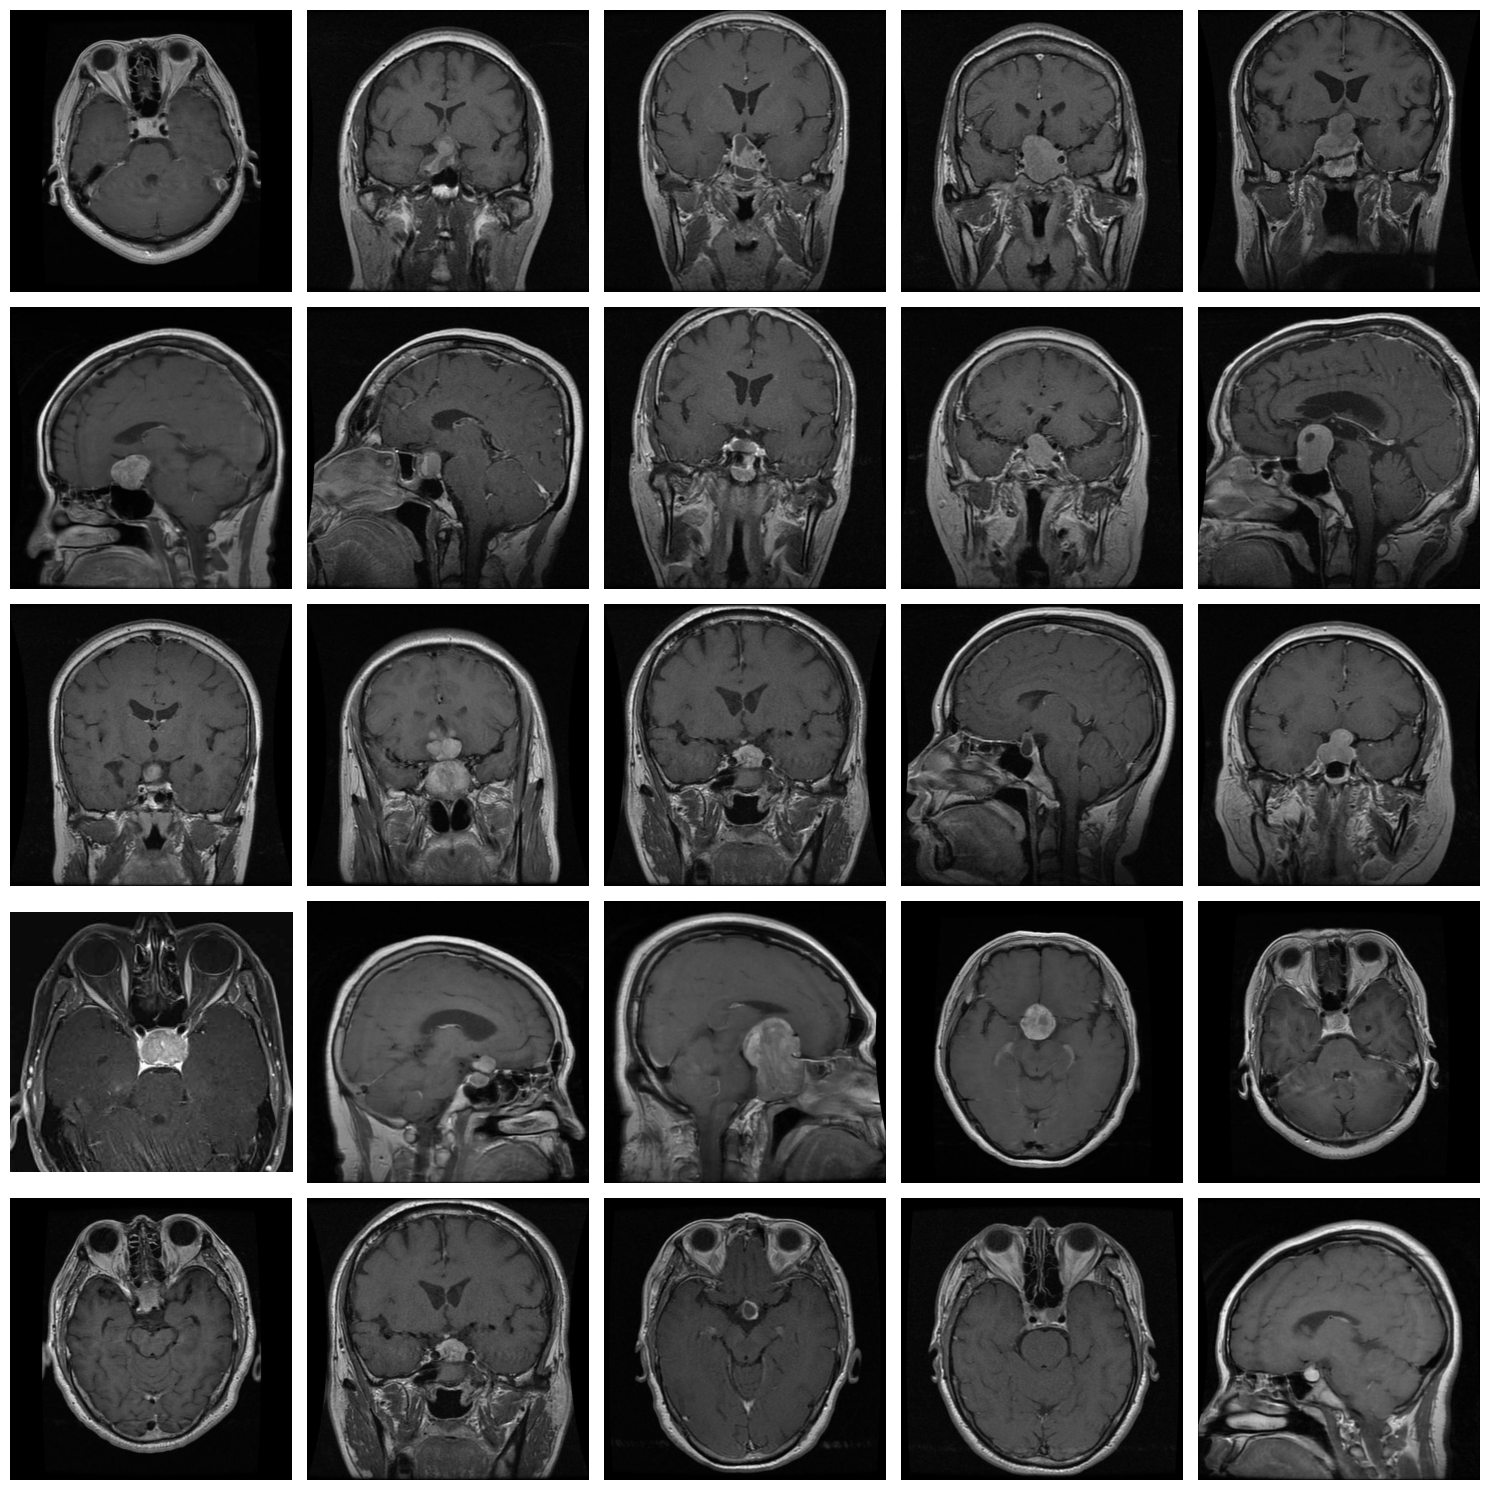

Image: Tr-pi_0505.jpg, Size: 512x512 pixels
Image: Tr-pi_0263.jpg, Size: 512x512 pixels
Image: p (477).jpg, Size: 512x512 pixels
Image: Tr-pi_0277.jpg, Size: 512x512 pixels
Image: Tr-pi_1169.jpg, Size: 512x512 pixels
Image: Tr-pi_0539.jpg, Size: 512x512 pixels
Image: p (162).jpg, Size: 512x512 pixels
Image: p (498).jpg, Size: 512x512 pixels
Image: p (532).jpg, Size: 512x512 pixels
Image: p (75).jpg, Size: 512x512 pixels
Image: Tr-pi_1182.jpg, Size: 512x512 pixels
Image: Tr-pi_1196.jpg, Size: 512x512 pixels
Image: Tr-pi_0288.jpg, Size: 512x512 pixels
Image: p (420).jpg, Size: 512x512 pixels
Image: p (565).jpg, Size: 512x512 pixels
Image: p (135).jpg, Size: 470x432 pixels
Image: Tr-pi_1431.jpg, Size: 512x512 pixels
Image: Tr-pi_1357.jpg, Size: 512x512 pixels
Image: p (22).jpg, Size: 512x512 pixels
Image: Te-pi_0019.jpg, Size: 512x512 pixels
Image: Te-pi_0031.jpg, Size: 512x512 pixels
Image: p (359).jpg, Size: 512x512 pixels
Image: Tr-pi_0934.jpg, Size: 512x512 pixels
Image: p (709).jpg, 

In [9]:

# Function to load unaugmented images
def load_unaugmented_images(directory, num_images=25):
    images = []
    sizes = []  # List to store sizes of images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        
        if not os.path.isdir(class_path):
            continue
            
        images_path = os.path.join(class_path, 'images')

        for image in os.listdir(images_path):
            if len(images) >= num_images:
                break
            
            img_path = os.path.join(images_path, image)
            img = cv2.imread(img_path)
            if img is not None:
                # Convert the image from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                
                # Get and store the size of the image
                height, width, _ = img.shape
                sizes.append((image, (width, height)))

        if len(images) >= num_images:
            break
    
    return images, sizes

# Path to the original unaugmented dataset
original_data_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'

# Load images (25 for a 5x5 grid)
unaugmented_images, image_sizes = load_unaugmented_images(original_data_path, num_images=25)

# Display the images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for ax, img in zip(axes.flatten(), unaugmented_images):
    ax.imshow(img)
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

# Print the sizes of the loaded images
for image_name, size in image_sizes:
    print(f"Image: {image_name}, Size: {size[0]}x{size[1]} pixels")


#### The unaugmented images are not consistent in size. They are also lacking augmention that could help create further variation which would help train a more robust model and reduce overfitting. Next I will augument the images and visualize the changes. 

## Augment Training Images

In [40]:
# Function to load images and labels 
def load_data(directory, target_size=(512, 512)):
    images = []
    labels = []
    
    # Create CLAHE object 
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10,10))
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if not os.path.isdir(class_path):
            print(f"Skipping non-directory: {class_path}")
            continue
        
        images_path = os.path.join(class_path, 'images')
        labels_path = os.path.join(class_path, 'labels')

        if not os.path.isdir(images_path) or not os.path.isdir(labels_path):
            print(f"Invalid directory structure in {class_path}. Skipping.")
            continue
        
        category_label = class_name 
        
        for image in os.listdir(images_path):
            if image.startswith('.'):  # Skip hidden files
                continue

            img_path = os.path.join(images_path, image)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image {image}, skipping.")
                continue
            
            # Resize the image to target size (512 x 512)
            img = cv2.resize(img, target_size)

            # convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            label_file = image.rsplit('.', 1)[0] + '.txt'  # Match the image and label file names
            label_file_path = os.path.join(labels_path, label_file)
            
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip()
                    
                    if label_data:
                        images.append(img)
                        labels.append(category_label)  # Append the category label
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    
    return images, labels

# Load training data
train_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'  
train_images, train_labels = load_data(train_path)

# Convert to NumPy array and scale images to [0, 1]
# Ensure all images have the same dimensions and convert to float32
train_images_np = np.array([img.astype(np.float32) / 255.0 for img in train_images])  # Ensure all images are in [0, 1]

# Set up data augmentation configuration using TensorFlow
datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)



Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train/.DS_Store


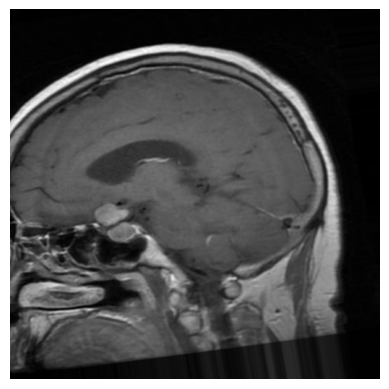

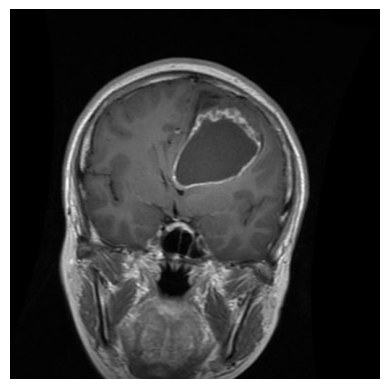

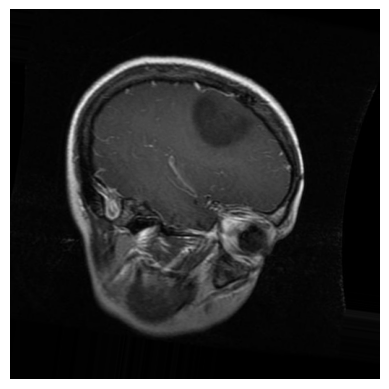

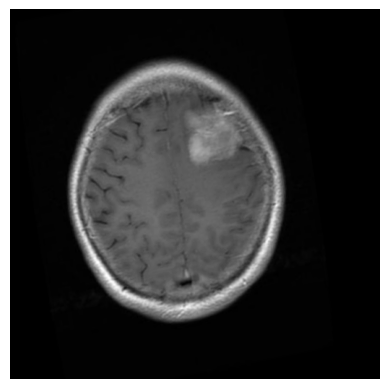

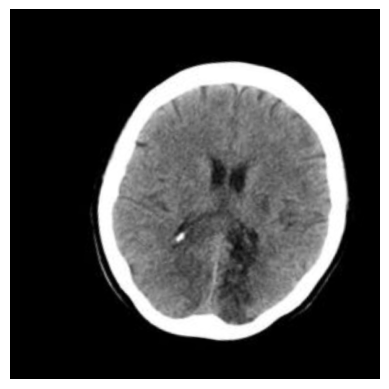

In [41]:

# Add a channel dimension to the grayscale images
train_images_np = np.expand_dims(train_images_np, axis=-1)  # Shape: (3670, 512, 512, 1)

# Set up data augmentation configuration using TensorFlow
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to preprocessed training images
datagen.fit(train_images_np)

# Function to display 5 random augmented images
def display_random_augmented_images(num_images=5):
    for _ in range(num_images):
        # Randomly select an image from the training set
        img_index = np.random.randint(0, len(train_images_np))
        img = train_images_np[img_index].reshape((1,) + train_images_np[img_index].shape)  # Reshape for the generator

        # Generate and display an augmented image
        augmented_image = next(datagen.flow(img, batch_size=1))[0]

        # Ensure the augmented image is in the correct format for display
        augmented_image = augmented_image.squeeze()  # Remove the channel dimension for display
        
        plt.imshow(augmented_image, cmap='gray')
        plt.axis('off')  # Turn off axis
        plt.show()

# Display 5 random augmented images
display_random_augmented_images(num_images=5)


# Exploratory Data Analysis


### 1. Visualize Sample Images


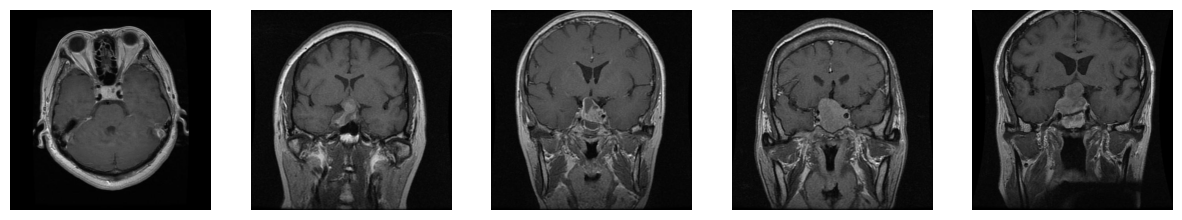

In [35]:
# Function to display random augmented images from the dataset
def display_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(dataset[i],cmap='gray')  # Display the image
        plt.axis('off')
    plt.show()

# Display 5 random augmented images
display_sample_images(train_images_np, num_samples=5)


The augmented images in the training data were altered using an image generator. The goal of augmentation was to make the images more suitable for model recognition by alerting their features randomly in regard to orientation, zooming, contrast from background, and detail definition.

All images in the 

### 2. Visualize Augmentation Effects

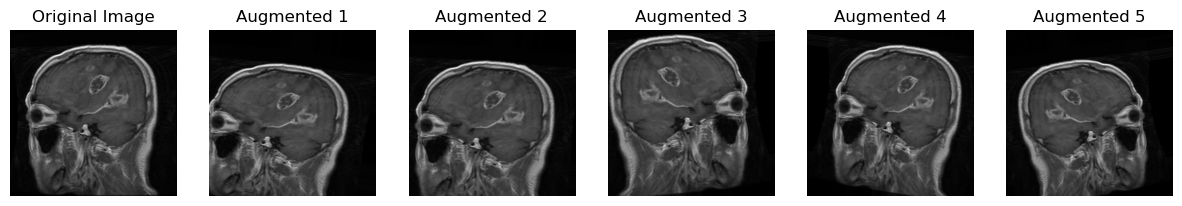

In [34]:
def visualize_augmentation_effects(original_image, datagen, num_augmented=5):
    plt.figure(figsize=(15, 5))
    
    # Display the original image
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(original_image,cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Generate and display augmented images
    img = original_image.reshape((1,) + original_image.shape)  # Reshape for the generator
    for i in range(num_augmented):
        augmented_image = next(datagen.flow(img, batch_size=1))[0]
        plt.subplot(1, num_augmented + 1, i + 2)
        plt.imshow(augmented_image,cmap='gray')
        plt.axis('off')
        plt.title(f'Augmented {i+1}')
        
    plt.show()

# Choose a random original image
original_index = np.random.randint(0, len(train_images_np))
visualize_augmentation_effects(train_images_np[original_index], datagen)


Using augmented images that are flipped, rotated, and zoomed in or out can be beneficial for training a machine learning model, especially in image classification tasks because:

- Augmentation introduces variability into the training dataset. This helps the model generalize better by exposing it to a wider range of scenarios and perspectives of the same object (in my case, brain images)

- Models trained on augmented data are often more robust to variations in input data, such as different angles, scales, or lighting conditions that they might encounter in real-world applications.

- By augmenting the dataset can help reduce overfitting. A model that sees only a limited number of training examples might learn to memorize them rather than generalizing.

### 3. Analyze Image Dimensions


In [36]:
# Analyze image dimensions
image_shapes = [img.shape for img in train_images_np]
print("Unique image shapes:", set(image_shapes))


Unique image shapes: {(512, 512, 1)}


- The shape of the images is, 512x512 pixels.
- 1 signifies that the images are in grayscale format.

### 4. Check Class Distribution

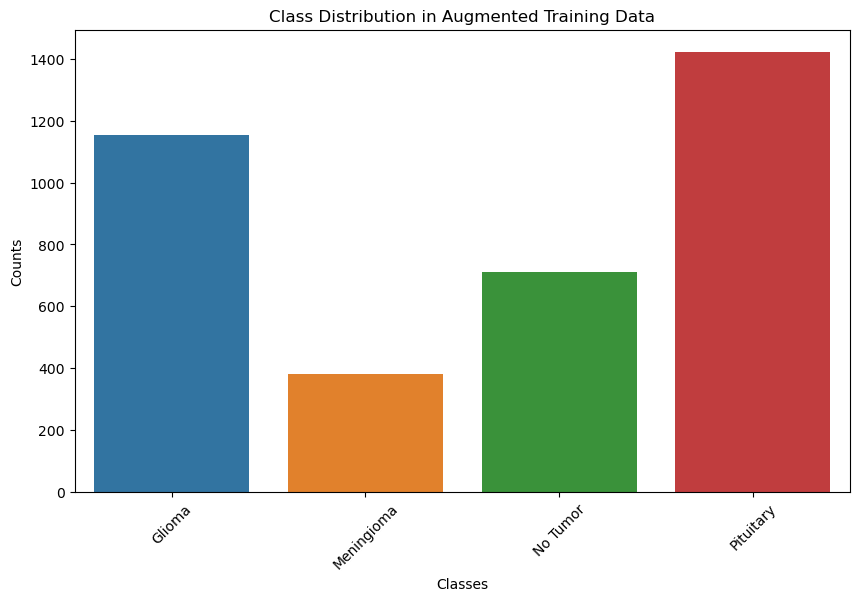

In [43]:
import seaborn as sns

# Calculate class distribution
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip(unique_labels, counts))

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in Augmented Training Data')
plt.xticks(rotation=45)
plt.show()


In [44]:
# Calculate class distribution
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip(unique_labels, counts))

# Print class distribution
print("Class Distribution in Augmented Training Data:")
for label, count in class_distribution.items():
    print(f"Class '{label}': {count} images")

Class Distribution in Augmented Training Data:
Class 'Glioma': 1153 images
Class 'Meningioma': 382 images
Class 'No Tumor': 711 images
Class 'Pituitary': 1424 images


## Conclusion

In this notebook, I conducted a thorough exploration and preprocessing of an MRI dataset from Kaggle. I successfully implemented several key steps, beginning with creating a function to load images and labels from a specified directory structure, ensuring that the images were resized, converted to grayscale, and accurately paired with their corresponding labels. This process was essential for maintaining consistency across my dataset. I then normalized the images by converting them to NumPy arrays and scaling the pixel values to a range of [0, 1], which is important for improving the performance of my CNN model. Additionally, I applied data augmentation techniques using ImageDataGenerator from Tensor Flow, allowing me to artificially expand my training dataset through transformations like rotation, shifting, and flipping. This not only helps create a more robust model but also aids in reducing overfitting.

Upon analyzing the class distribution, I discovered a significant imbalance among the classes, with some categories, such as 'Pituitary' and 'Glioma,' having substantially more images compared to others like 'Meningioma.' This imbalance can lead to bias during model training and evaluation. To address this issue in my upcoming modeling notebook, I will implement strategies such as calculating class weights to prioritize the minority classes during training. I may also explore oversampling techniques, such as SMOTE, to generate synthetic samples for the underrepresented classes. Moreover, I will prioritize evaluation metrics like F1-score, precision, and recall to gauge model performance effectively, rather than relying solely on accuracy. By integrating these strategies, I aim to develop a more robust model capable of accurately classifying brain tumors, thereby enhancing its generalizability and predictive power in clinical applications.